# Coursework for Cardiac MR Image Segmentation (2021-2022)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

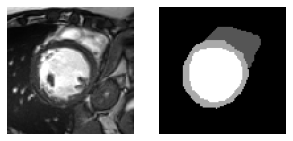

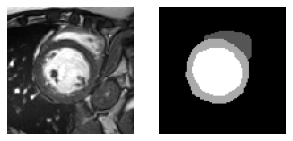

True

In [2]:
import os
import cv2 #import OpenCV

data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')

image2 = cv2.imread(os.path.join(data_dir,'image','cmr2.png'), cv2.IMREAD_UNCHANGED)
mask2 = cv2.imread(os.path.join(data_dir,'mask','cmr2_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image2, mask2, cmap='gray')


plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

In [3]:
import torch
# Check the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

The current device is cuda:0


## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [4]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
 
BatchNorm2d = nn.BatchNorm2d
import cv2
import matplotlib.pyplot as plt
 
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,dilation=dilation, padding=dilation, bias=False)
        self.bn2 = BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation
 
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
 
 
class ResNet(nn.Module):
    def __init__(self, nInputChannels, block, layers, os=16, pretrained=False):
        self.inplanes = 64
        super(ResNet, self).__init__()
        if os == 16:
            strides = [1, 2, 2, 1]
            dilations = [1, 1, 1, 2]
            blocks = [1, 2, 4]
        elif os == 8:
            strides = [1, 2, 1, 1]
            dilations = [1, 1, 2, 2]
            blocks = [1, 2, 1]
        else:
            raise NotImplementedError
        # Modules
        self.conv1 = nn.Conv2d(nInputChannels, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
 
        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], dilation=dilations[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], dilation=dilations[1])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], dilation=dilations[2])
        self.layer4 = self._make_MG_unit(block, 512, blocks=blocks, stride=strides[3], dilation=dilations[3])
        self._init_weight()
 
 
    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
 
 
    def _make_MG_unit(self, block, planes, blocks=[1, 2, 4], stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation=blocks[0]*dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, len(blocks)):
            layers.append(block(self.inplanes, planes, stride=1, dilation=blocks[i]*dilation))
 
        return nn.Sequential(*layers)
 
 
    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        low_level_feat = x
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, low_level_feat
 
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
 
 
 
    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('https://download.pytorch.org/models/resnet101-5d3b4d8f.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)
 
 
def ResNet101(nInputChannels=3, os=16, pretrained=False):
    model = ResNet(nInputChannels, Bottleneck, [3, 4, 23, 3], os, pretrained=pretrained)
    return model
 
 
 
class ASPP_module(nn.Module):
    def __init__(self, inplanes, planes, dilation):
        super(ASPP_module, self).__init__()
        if dilation == 1:
            kernel_size = 1
            padding = 0
        else:
            kernel_size = 3
            padding = dilation
        self.atrous_convolution = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self._init_weight()
 
    def forward(self, x):
        x = self.atrous_convolution(x)
        x = self.bn(x)
        return self.relu(x)
 
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class DeepLabv3_plus(nn.Module):
    def __init__(self, nInputChannels=3, n_classes=21, os=16, pretrained=False, freeze_bn=False, _print=True):
        if _print:
            print("Constructing DeepLabv3+ model...")
            print("Backbone: Resnet-101")
            print("Number of classes: {}".format(n_classes))
            print("Output stride: {}".format(os))
            print("Number of Input Channels: {}".format(nInputChannels))
        super(DeepLabv3_plus, self).__init__()
 
        self.resnet_features = ResNet101(nInputChannels, os, pretrained=pretrained)
 
        if os == 16:
            dilations = [1, 6, 12, 18]
        elif os == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError
            
        self.aspp1 = ASPP_module(2048, 256, dilation=dilations[0])
        self.aspp2 = ASPP_module(2048, 256, dilation=dilations[1])
        self.aspp3 = ASPP_module(2048, 256, dilation=dilations[2])
        self.aspp4 = ASPP_module(2048, 256, dilation=dilations[3])
        self.relu = nn.ReLU()
 
        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(2048, 256, 1, stride=1, bias=False),
                                             BatchNorm2d(256),
                                             nn.ReLU())
 
 
 
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = BatchNorm2d(256)
 
        # adopt [1x1, 48] for channel reduction.
        self.conv2 = nn.Conv2d(256, 48, 1, bias=False)
        self.bn2 = BatchNorm2d(48)
        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, n_classes, kernel_size=1, stride=1))
 
        if freeze_bn:
            self._freeze_bn()
 
 
    def forward(self, input):
        x, low_level_features = self.resnet_features(input)
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = F.interpolate(x, size=(int(math.ceil(input.size()[-2]/4)),
                                int(math.ceil(input.size()[-1]/4))), mode='bilinear', align_corners=True)
 
        low_level_features = self.conv2(low_level_features)
        low_level_features = self.bn2(low_level_features)
        low_level_features = self.relu(low_level_features)
 
 
        x = torch.cat((x, low_level_features), dim=1)
        x = self.last_conv(x)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)
        return x
 
    def _freeze_bn(self):
        for m in self.modules():
            if isinstance(m, BatchNorm2d):
                m.eval()
 
 
 
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
def get_1x_lr_params(model):
    """
    This generator returns all the parameters of the net except for
    the last classification layer. Note that for each batchnorm layer,
    requires_grad is set to False in deeplab_resnet.py, therefore this function does not return
    any batchnorm parameter
    """
    b = [model.resnet_features]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k
                
def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the last layer of the net,
    which does the classification of pixel into classes
    """
    b = [model.aspp1, model.aspp2, model.aspp3, model.aspp4, model.conv1, model.conv2, model.last_conv]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k

                              

deeplab = DeepLabv3_plus(nInputChannels=1, n_classes=4, os=8, _print=True)
deeplab.eval()
deeplab = deeplab.to(device)


Constructing DeepLabv3+ model...
Backbone: Resnet-101
Number of classes: 4
Output stride: 8
Number of Input Channels: 1


### 2.3 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [6]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 2.4 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [7]:
import torch.optim as optim



# Optimizer

def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=10):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.5**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    print('LR:', lr)
    return optimizer

LR = 0.001
weight_decay=1e-4
optimizer = torch.optim.Adam(deeplab.parameters(), lr = LR, weight_decay=weight_decay)




# Loss function
# Loss = nn.CrossEntropyLoss()

class losses():
    def __init__(self):
        self.CE= nn.CrossEntropyLoss()
        
    def forward(self, pred, true):    
        return self.CE(pred,true)

    def forward2(self,pred,true,pred_mask,true_mask):
        self.val = 0
        for i in range(3):
            self.val = self.val + categorical_dice(pred_mask.data.cpu().numpy(), true_mask.data.cpu().numpy(), i+1)
        
        return self.CE(pred,true) + (3 - self.val)/7
Loss = losses()

### 2.5 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [8]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
import time

# Epoch
EPOCH = 50

data_path = './data/train'
num_workers = 4
batch_size = 1
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

# train_losses = []
# val_losses = []

# train_dice_plt = []
# val_dice_plt = []
max_score = 0
t0 = time.time()
for epoch in range(EPOCH): 
    train_loss_total = 0
    train_loss_mean = 0

    score_train_total1 = 0
    score_train_total2 = 0
    score_train_total3 = 0
    score_train_total = 0
    score_train_mean = 0

    score_validation_total1 = 0
    score_validation_total2 = 0
    score_validation_total3 = 0
    score_validation_total = 0
    score_validation_mean = 0
    
    optimizer = exp_lr_scheduler(optimizer, epoch)
    
    # Fetch images and labels
    for iteration, sample in enumerate(training_data_loader):
        img, mask = sample 

        #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
        #plt.pause(1)

        # Write your FORWARD below
        # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
        # Then write your BACKWARD & OPTIMIZE below
        # Note: Compute Loss and Optimize

        x = img
        y = mask

        # adjust the dimension
        x_var = Variable(torch.unsqueeze(x, dim=0).float(), requires_grad=False)
        
        # add x and y to the device
        x_var = x_var.to(device)
        y = y.to(device)
        
        # gradient -> 0
        optimizer.zero_grad()

        # output
        output = deeplab(x_var)

        # loss
        # loss = Loss(output, y.long())
        output_ss = output.argmax(dim=1)
        loss = Loss.forward2(output,y.long(),mask, output_ss)
        loss.backward()

        # optimizer
        optimizer.step()

        # training loss
        train_loss_total = train_loss_total + loss   

        # Reduce the dimension and get the training score on the training set
        _,output_train = torch.max(output, 1)
        score_train_total1 = score_train_total1 + categorical_dice(output_train.data.cpu().numpy(), y.data.cpu().numpy(),1)
        score_train_total2 = score_train_total2 + categorical_dice(output_train.data.cpu().numpy(), y.data.cpu().numpy(),2)
        score_train_total3 = score_train_total3 + categorical_dice(output_train.data.cpu().numpy(), y.data.cpu().numpy(),3)        

    # After 1 for-loop on the dataset
    # Output the Train_Loss_Mean
    train_loss_mean = train_loss_total/100
    print("Epoch:{0} ||  Train_Loss_Mean:{1}".format(epoch, format(train_loss_mean, ".4f"))) 
    
    # if epoch > 1:
       # train_losses.append(train_loss_mean)
    
    # Output the Train_Score_Mean
    score_train_total = score_train_total1 + score_train_total2 + score_train_total3
    score_train_mean = score_train_total/300             
    print('Train_Score_Mean', score_train_mean)
    
    # train_dice_plt.append(score_train_mean)
    
    # Output the Validation Loss in the end of the epoch
    validation_loss_total = 0
    data_path_val = './data/val'
    validation_set = TrainDataset(data_path_val)
    validation_data_loader = DataLoader(dataset=validation_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

    # for-loop on the validation set
    for iteration_t, sample in enumerate(validation_data_loader):
        img, mask = sample 

        # adjust the dimension
        x_var = Variable(torch.unsqueeze(img, dim=0).float(), requires_grad=False)
        
        # add x and y to the device
        x_var = x_var.to(device)
        mask = mask.to(device)
        
        # output
        output = deeplab(x_var)

        # loss
        # loss = Loss(output, mask.long())
        output_ss = output.argmax(dim=1)
        loss = Loss.forward2(output,mask.long(),mask, output_ss)      
        
        validation_loss_total = validation_loss_total + loss
        
        # Reduce the dimension and get the validation score on the validation set
        _,output_validation = torch.max(output, 1)
        score_validation_total1 = score_validation_total1 + categorical_dice(output_validation.data.cpu().numpy(), mask.data.cpu().numpy(),1)
        score_validation_total2 = score_validation_total2 + categorical_dice(output_validation.data.cpu().numpy(), mask.data.cpu().numpy(),2)
        score_validation_total3 = score_validation_total3 + categorical_dice(output_validation.data.cpu().numpy(), mask.data.cpu().numpy(),3)
        
    # Validation_Loss_Mean
    validation_loss_mean = validation_loss_total/20
    print('Validation_Loss_Mean', validation_loss_mean)
    
    # val_losses.append(validation_loss_mean)
    
    # Output the Train_Score_Mean
    score_validation_total = score_validation_total1 + score_validation_total2 + score_validation_total3
    score_validation_mean = score_validation_total/60             
    print('Validation_Score_Mean', score_validation_mean)
    
    if max_score < score_validation_mean:
        max_score = score_validation_mean
        PATH = './deeplab_resnet.pth'
        torch.save(deeplab.state_dict(), PATH)
    
    # val_dice_plt.append(score_validation_mean)

    print('\n')        
    
print('Finished Training')       

t1 = time.time()
print('Finished Training in %.3f seconds' % (t1- t0))

# print(len(train_losses))
# print(len(val_losses))
# plt.plot(range(EPOCH-1), train_losses,c='r',label = "train_losses")
# plt.plot(range(EPOCH), val_losses,c='y',label = "val_losses") # 
# plt.legend(loc='best')
# plt.savefig('Deeplab_resnet_1.jpg')
# plt.show()

# plt.plot(range(EPOCH-1), train_dice_plt,c='r',label = "training dice score")
# plt.plot(range(EPOCH), val_dice_plt,c='y',label = "validation dice score")
# plt.legend(loc='best')
# plt.savefig('Deeplab_resnet_2.jpg')
 #plt.show()

LR is set to 0.001
LR: 0.001


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Epoch:0 ||  Train_Loss_Mean:nan
Train_Score_Mean nan
Validation_Loss_Mean tensor(0.8305, device='cuda:0', grad_fn=<DivBackward0>)
Validation_Score_Mean 0.10259950414127218


LR: 0.001
Epoch:1 ||  Train_Loss_Mean:nan
Train_Score_Mean nan
Validation_Loss_Mean tensor(0.6378, device='cuda:0', grad_fn=<DivBackward0>)
Validation_Score_Mean 0.3277372199571842


LR: 0.001
Epoch:2 ||  Train_Loss_Mean:nan
Train_Score_Mean nan
Validation_Loss_Mean tensor(0.6644, device='cuda:0', grad_fn=<DivBackward0>)
Validation_Score_Mean 0.38050031768014597


LR: 0.001
Epoch:3 ||  Train_Loss_Mean:0.5936
Train_Score_Mean 0.3965645922343732
Validation_Loss_Mean tensor(0.5077, device='cuda:0', grad_fn=<DivBackward0>)
Validation_Score_Mean 0.49136154051853737


LR: 0.001
Epoch:4 ||  Train_Loss_Mean:nan
Train_Score_Mean nan
Validation_Loss_Mean tensor(0.5439, device='cuda:0', grad_fn=<DivBackward0>)
Validation_Score_Mean 0.46352044124756325


LR: 0.001
Epoch:5 ||  Train_Loss_Mean:0.5121
Train_Score_Mean 0.476626779

In [9]:
#PATH = './deeplab_resnet.pth'
#torch.save(deeplab.state_dict(), PATH)

### 2.5.1 Generate the mask on the validation set


 0 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


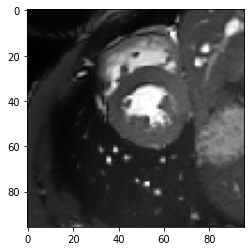

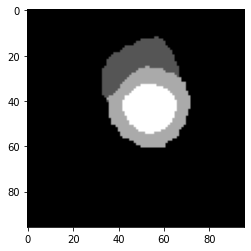

color_validation torch.Size([1, 96, 96])


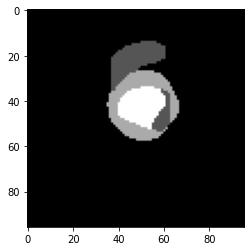


 1 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


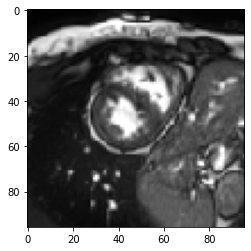

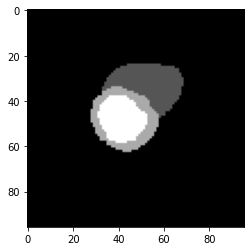

color_validation torch.Size([1, 96, 96])


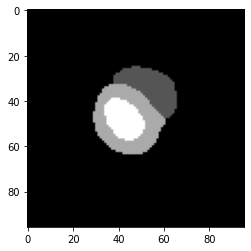


 2 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


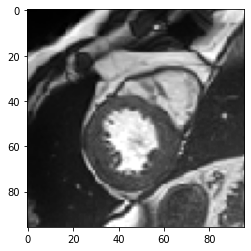

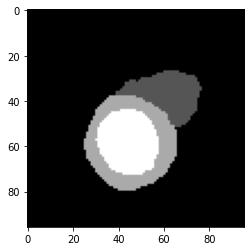

color_validation torch.Size([1, 96, 96])


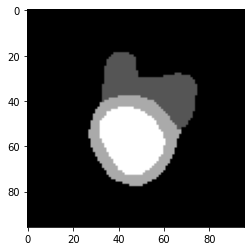


 3 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


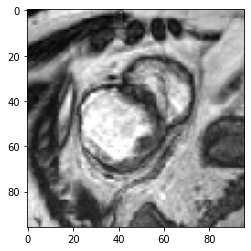

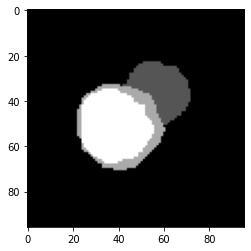

color_validation torch.Size([1, 96, 96])


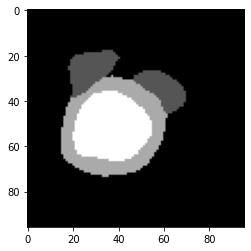


 4 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


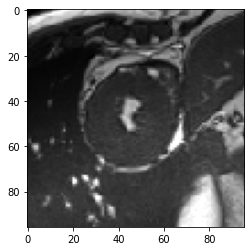

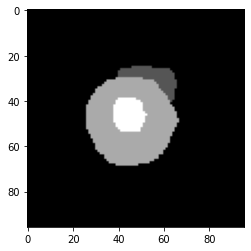

color_validation torch.Size([1, 96, 96])


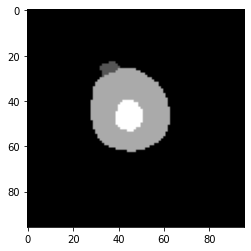


 5 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


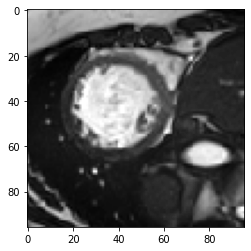

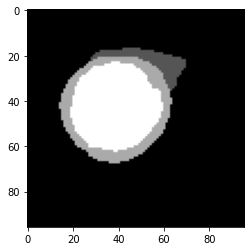

color_validation torch.Size([1, 96, 96])


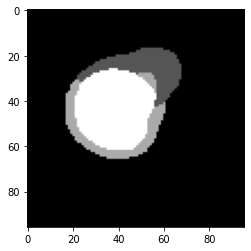


 6 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


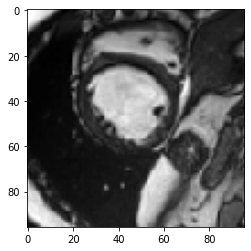

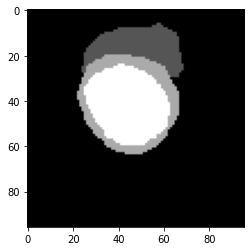

color_validation torch.Size([1, 96, 96])


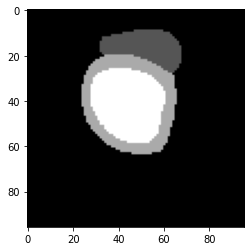


 7 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


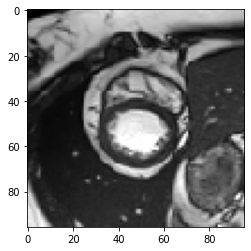

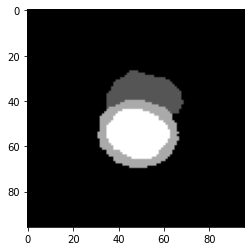

color_validation torch.Size([1, 96, 96])


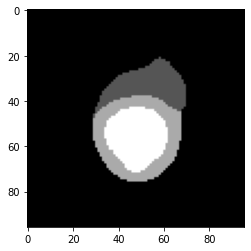


 8 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


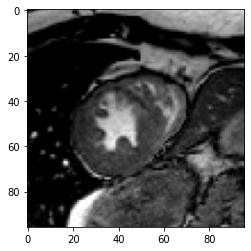

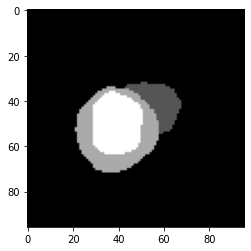

color_validation torch.Size([1, 96, 96])


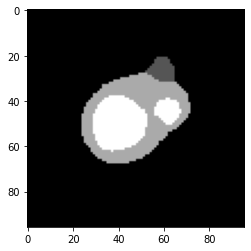


 9 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


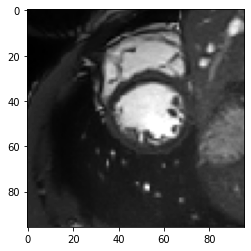

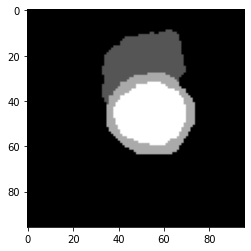

color_validation torch.Size([1, 96, 96])


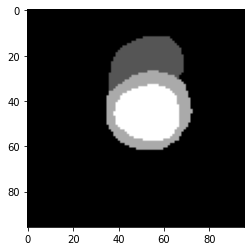


 10 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


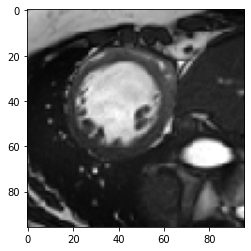

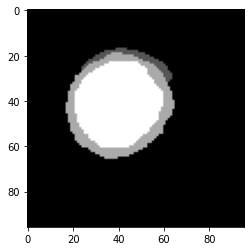

color_validation torch.Size([1, 96, 96])


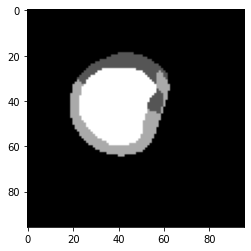


 11 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


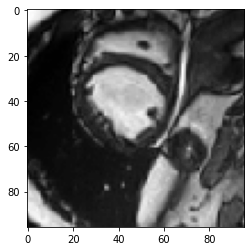

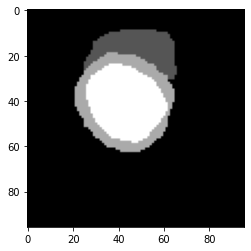

color_validation torch.Size([1, 96, 96])


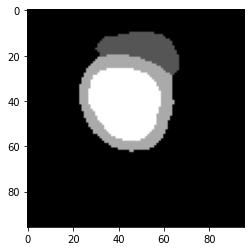


 12 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


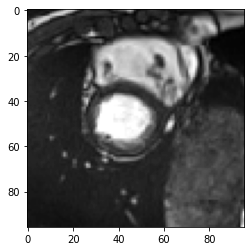

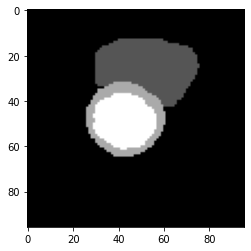

color_validation torch.Size([1, 96, 96])


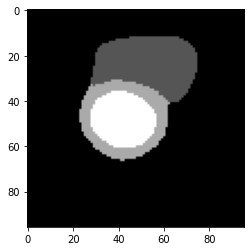


 13 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


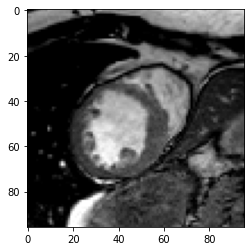

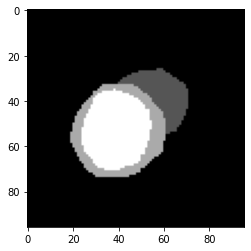

color_validation torch.Size([1, 96, 96])


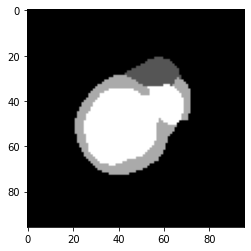


 14 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


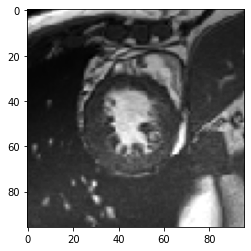

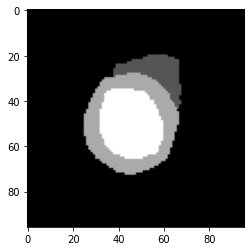

color_validation torch.Size([1, 96, 96])


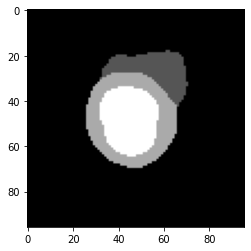


 15 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


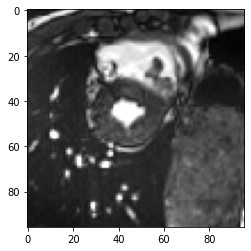

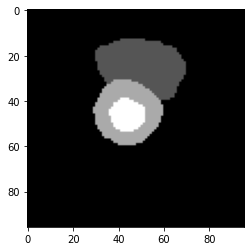

color_validation torch.Size([1, 96, 96])


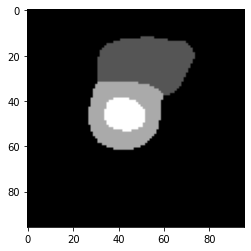


 16 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


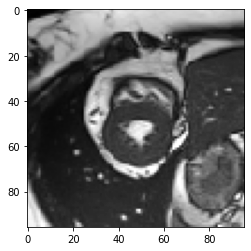

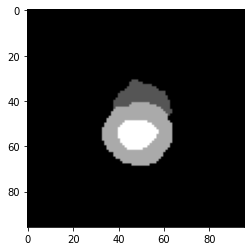

color_validation torch.Size([1, 96, 96])


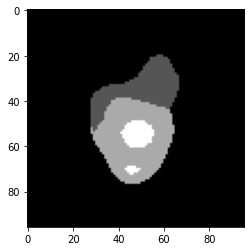


 17 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


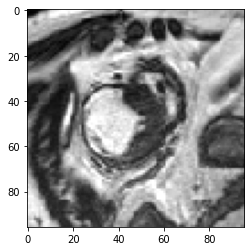

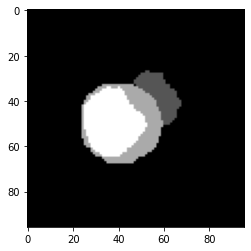

color_validation torch.Size([1, 96, 96])


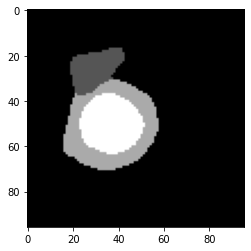


 18 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


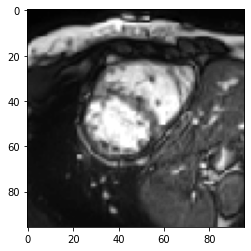

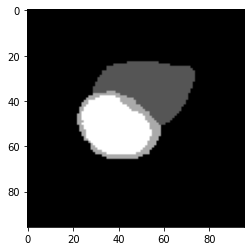

color_validation torch.Size([1, 96, 96])


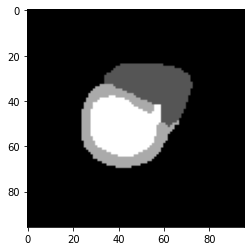


 19 torch.Size([1, 96, 96]) torch.Size([1, 96, 96])


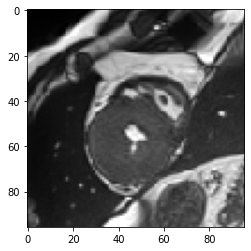

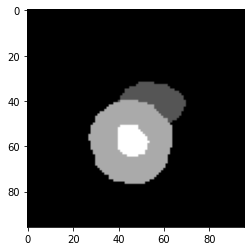

color_validation torch.Size([1, 96, 96])


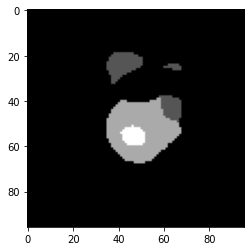

Finish


In [10]:
data_path_val = './data/val'
validation_set = TrainDataset(data_path_val)
validation_data_loader = DataLoader(dataset=validation_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

for iteration, sample in enumerate(validation_data_loader):
             
        #if iteration > 2:
         #   pass
        
        #else:
            img, mask = sample
            print('\n',iteration,img.shape,mask.shape)
        
            plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
            plt.pause(0.1)
            plt.imshow(mask[0,...].squeeze(), cmap='gray') #visualise all masks in test set
            plt.pause(0.1)
           
            # adjust the dimension and generate the mask based on the model SegNet 
            validation_img = Variable(torch.unsqueeze(img, dim=0).float(), requires_grad=False).to(device)
            validation_output = deeplab(validation_img)
            max_validation,color_validation = torch.max(validation_output, 1)
            print('color_validation', color_validation.shape)
            color_validation = color_validation.data.cpu()
            plt.imshow(color_validation[0,...].squeeze(), cmap='gray') #visualise all masks in test set
            plt.pause(0.1)
            
print('Finish')
        


### 2.6 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [11]:
import numpy as np
from torch.autograd import Variable

In [12]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Automatically created module for IPython interactive environment


Constructing DeepLabv3+ model...
Backbone: Resnet-101
Number of classes: 4
Output stride: 16
Number of Input Channels: 1
validation loss: 1.180
Confusion matrix, without normalization
[[0.94 0.16 0.46 0.32]
 [0.04 0.38 0.05 0.03]
 [0.02 0.22 0.2  0.2 ]
 [0.01 0.24 0.3  0.44]]


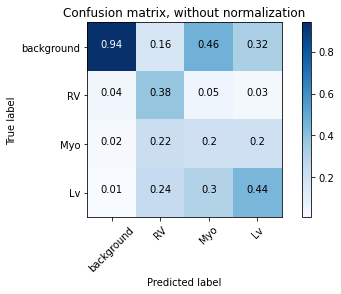

In [13]:
# validation on validation set, compute the loss
from torch.utils.data import DataLoader
import numpy as np
y_mmpre = []
y_mmlabel = []

PATH = './deeplab_resnet.pth'
val_data_path = './data/val'
num_workers = 0
batch_size = 1

val_set = TrainDataset(val_data_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=1, shuffle=False)
model = DeepLabv3_plus(1, 4)
model.load_state_dict(torch.load(PATH))

with torch.no_grad():       # fix the model's params (reduces cost)
    model.eval()       # set model to evaluation mode
    validation_loss = 0.0
    for iteration, sample in enumerate(val_data_loader):
        img, mask = sample
        #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
        #plt.pause(1)
        img = img.view(batch_size, 1, 96, 96)

        # forward
        outputs = model(img)
                   
        # compute loss
        loss = Loss.forward2(output,y.long(),mask, output_ss)
        validation_loss += loss.item()
        #print(loss.item())
        
        outputs2 = output.argmax(dim = 1)
           
        for i in range(96):
            for j in range(96):
                y_mmpre.append(int(outputs2[0][i][j].item()))
                y_mmlabel.append(int(mask[0][i][j].item()))
    
    # compute the validation loss on full validation set
    validation_loss /= 20.0
      
    
    # print the training and validation loss per epoch
    print('validation loss: %.3f' % (validation_loss))


cm = np.zeros((4, 4)) # matrics
cnt = [0, 0, 0, 0]

#for i in range(4):
#    print(y_mmlabel[i])
for i in range(len(y_mmlabel)):
    cnt[y_mmlabel[i]] = cnt[y_mmlabel[i]] + 1
    
for i in range(len(y_mmpre)):
    cm[y_mmpre[i]][y_mmlabel[i]] = cm[y_mmpre[i]][y_mmlabel[i]] + 1

for i in range(4):
    for j in range(4):
        cm[i][j] = cm[i][j] / cnt[j]
        cm[i][j] = round(cm[i][j], 2)
        
class_names = ['background', 'RV', 'Myo', 'Lv']

# y_mlabel = np.array(y_mmlabel)
# y_mpre = np.array(y_mmpre)

# cnf_matrix = confusion_matrix(y_mlabel, y_mpre)
# for i in range(4):
#    for j in range(4):
#        cnf_matrix[i][j] = round(cnf_matrix[i][j], 2)

# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')
plt.savefig('Deeplab_resnet_3.jpg')
plt.show()
    
#print("validation total loss: %f" % (val_total_loss))
#val_eva_loss = val_total_loss / (val_batch_size * len(val_data_loader))
#print("validation total loss: %f" % (val_eva_loss))

In [14]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
#data_path = '/content/drive/MyDrive/CW/data/test'
#num_workers = 5
#batch_size = 1

#test_set = TestDataset(data_path)
#test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

#for iteration, sample in enumerate(test_data_loader):
    #img = sample
    #print(img.shape)

    #plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    #plt.pause(1)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [15]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()